importing libraries

In [1]:
# Import PyTorch
import torch

# We use torchvision to get our dataset and useful image transformations
import torchvision
import torchvision.transforms as transforms

# Import PyTorch's optimization libary and nn
# nn is used as the basic building block for our Network graphs
import torch.optim as optim
import torch.nn as nn

# Are we using our GPU?
print("GPU available: {}".format(torch.cuda.is_available()))

GPU available: True


importing and unzipping the dataset


In [1]:
from google.colab import files

# Upload the .zip file
uploaded = files.upload()

# Extract the contents of the .zip file
import zipfile
import io

with zipfile.ZipFile("/content/brain_tumor_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')
    zip_ref.close()

Saving brain_tumor_dataset.zip to brain_tumor_dataset.zip


In [2]:
import tensorflow as tf
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os

In [3]:
data_dir = '/content/dataset/brain_tumor_dataset'
os.listdir(data_dir)

['yes', 'no']

In [4]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 253 files belonging to 2 classes.


In [5]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()


normalizing data

In [7]:
data = data.map(lambda x,y: (x/255, y))
scaled_iterator=data.as_numpy_iterator().next()

creating train and validation and test data

In [8]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.15)
test_size = int(len(data)*.15)

In [9]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [10]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout , SeparableConv2D, Add, Input, BatchNormalization
from tensorflow.keras import regularizers

residual blocks

In [12]:
'''from tensorflow.keras import layers

def residual_block(model, filters, kernel_size):
    y = SeparableConv2D(filters, kernel_size, activation='relu', padding='same')(model.output)
    y = SeparableConv2D(filters, kernel_size, activation='relu', padding='same')(y)
    y = Add()([model.output, y])  # Add skip connection
    y = MaxPooling2D(pool_size=(2, 2))(y)
    y = Dropout(0.25)(y)
    return y'''

"from tensorflow.keras import layers\n\ndef residual_block(model, filters, kernel_size):\n    y = SeparableConv2D(filters, kernel_size, activation='relu', padding='same')(model.output)\n    y = SeparableConv2D(filters, kernel_size, activation='relu', padding='same')(y)\n    y = Add()([model.output, y])  # Add skip connection\n    y = MaxPooling2D(pool_size=(2, 2))(y)\n    y = Dropout(0.25)(y)\n    return y"

In [13]:
''' model = Sequential()
model.add(Input(shape=(256, 256, 3)))

model.add(SeparableConv2D(32, kernel_size=(3,3), activation='relu', padding='same'))


# First residual block
model.add(residual_block(model, filters=32, kernel_size=(3, 3)))

# Second residual block
#model.add(residual_block(model.layers[-1].output, filters=128, kernel_size=(3, 3)))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))'''

" model = Sequential()\nmodel.add(Input(shape=(256, 256, 3)))\n\nmodel.add(SeparableConv2D(32, kernel_size=(3,3), activation='relu', padding='same'))\n\n\n# First residual block\nmodel.add(residual_block(model, filters=32, kernel_size=(3, 3)))\n\n# Second residual block\n#model.add(residual_block(model.layers[-1].output, filters=128, kernel_size=(3, 3)))\n\n# Flatten layer\nmodel.add(Flatten())\n\n# Dense layers\nmodel.add(Dense(256, activation='relu'))\nmodel.add(Dense(1, activation='sigmoid'))"

In [14]:
#model.add(SeparableConv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256,256,3)))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
#model.add(SeparableConv2D(64, kernel_size=(3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))

In [15]:
model = Sequential()
model.add(SeparableConv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())  # Batch Normalization
model.add(Dropout(0.25))
model.add(SeparableConv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())  # Batch Normalization
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # Add L2 Regularization
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

##part 4

#early stoping

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping callback
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/30
5/5 [==============================] - 30s 5s/step - loss: 46.6905 - accuracy: 0.6438 - val_loss: 1.4956 - val_accuracy: 0.6875
Epoch 2/30
5/5 [==============================] - 24s 5s/step - loss: 11.8072 - accuracy: 0.8250 - val_loss: 1.7092 - val_accuracy: 0.7500
Epoch 3/30
5/5 [==============================] - 30s 5s/step - loss: 9.7500 - accuracy: 0.8188 - val_loss: 2.1617 - val_accuracy: 0.7500
Epoch 4/30
5/5 [==============================] - 24s 5s/step - loss: 5.2010 - accuracy: 0.8062 - val_loss: 2.8119 - val_accuracy: 0.6250
Epoch 4: early stopping
1/1 [==============================] - 1s 1s/step - loss: 1.6571 - accuracy: 0.5938
Test Loss: 1.6570868492126465
Test Accuracy: 0.59375


plotting loss and accuracy

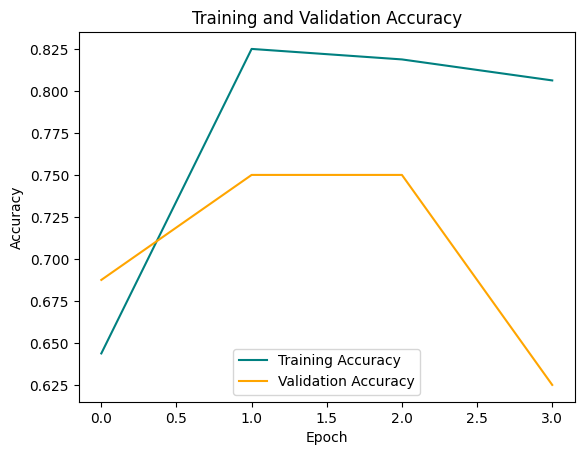

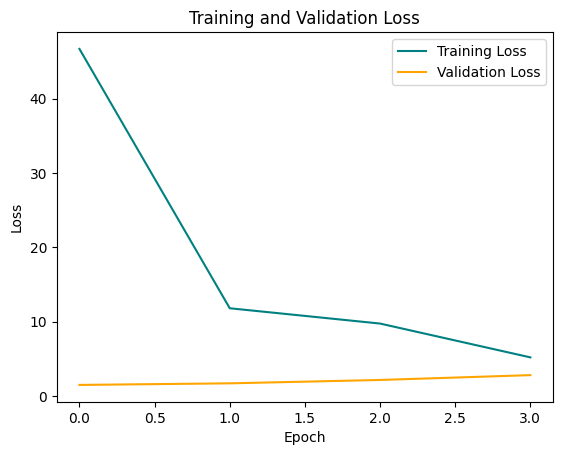

In [21]:
# Plot training and validation accuracy
plt.plot(hist.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist.history['loss'], color='teal', label='Training Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

calculate confusion matrix

In [27]:
from sklearn.metrics import confusion_matrix

# Predict labels for the test set
test_predictions = model.predict(test)
test_predictions = (test_predictions > 0.5).astype(int)

# Extract true labels from the test set
test_labels = []
for _, label in test:
    test_labels.append(label.numpy())

test_labels = np.concatenate(test_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)


1/1 [==============================] - 2s 2s/step
Confusion Matrix:
[[ 8  7]
 [ 5 12]]


#L2 regularization

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

#defining again(in case)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import regularizers

# Define the model
model = Sequential()
model.add(SeparableConv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(SeparableConv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 30 epochs
hist = model.fit(train, epochs=30, validation_data=val)


Epoch 1/30
5/5 [==============================] - 22s 4s/step - loss: 55.1929 - accuracy: 0.7000 - val_loss: 1.7967 - val_accuracy: 0.5938
Epoch 2/30
5/5 [==============================] - 21s 4s/step - loss: 44.5556 - accuracy: 0.7625 - val_loss: 2.4851 - val_accuracy: 0.6562
Epoch 3/30
5/5 [==============================] - 21s 4s/step - loss: 8.4899 - accuracy: 0.8250 - val_loss: 4.9588 - val_accuracy: 0.5000
Epoch 4/30
5/5 [==============================] - 20s 4s/step - loss: 3.5809 - accuracy: 0.8375 - val_loss: 5.4569 - val_accuracy: 0.5000
Epoch 5/30
5/5 [==============================] - 21s 4s/step - loss: 2.8231 - accuracy: 0.8438 - val_loss: 3.7764 - val_accuracy: 0.7500
Epoch 6/30
5/5 [==============================] - 20s 4s/step - loss: 2.6390 - accuracy: 0.8375 - val_loss: 4.4255 - val_accuracy: 0.6875
Epoch 7/30
5/5 [==============================] - 22s 4s/step - loss: 2.2825 - accuracy: 0.8125 - val_loss: 5.2212 - val_accuracy: 0.6250
Epoch 8/30
5/5 [================

plotting training and validation accuracy/loss

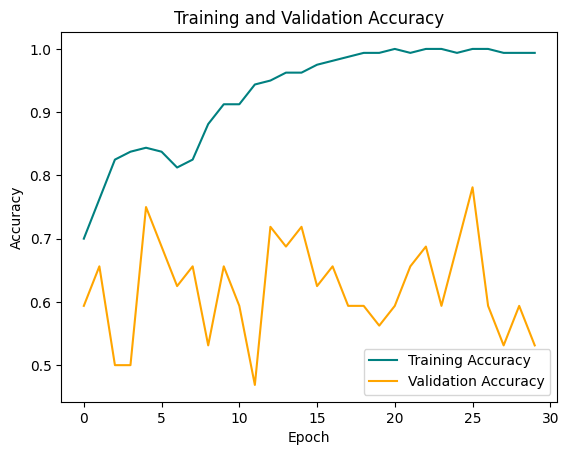

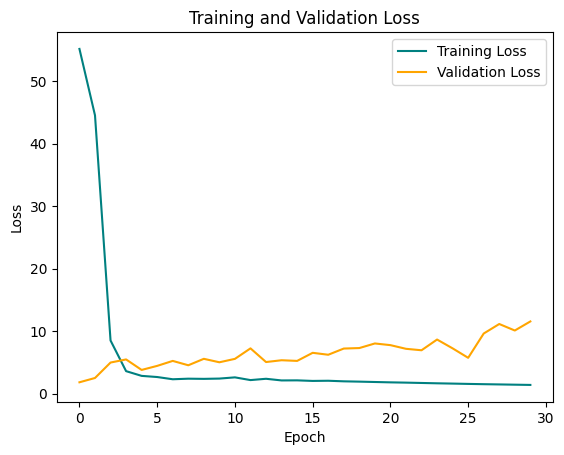

In [34]:
# Plot training and validation accuracy
plt.plot(hist.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist.history['loss'], color='teal', label='Training Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test accuracy

In [35]:
test_loss, test_accuracy = model.evaluate(test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Generate predictions for the test set
test_predictions = model.predict(test)
test_predictions = (test_predictions > 0.5).astype(int)

# Extract true labels from the test set
test_labels = []
for _, label in test:
    test_labels.append(label.numpy())

test_labels = np.concatenate(test_labels)

1/1 [==============================] - 3s 3s/step - loss: 9.5735 - accuracy: 0.6250
Test Loss: 9.573481559753418
Test Accuracy: 0.625
1/1 [==============================] - 1s 1s/step


calculate confusion matrix

In [47]:
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[11  0]
 [21  0]]


#Drop out and L2 regularization

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import regularizers

# Define the model
model = Sequential()
model.add(SeparableConv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(SeparableConv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 30 epochs
hist = model.fit(train, epochs=30, validation_data=val)

Epoch 1/30
5/5 [==============================] - 28s 5s/step - loss: 45.4944 - accuracy: 0.6938 - val_loss: 1.8653 - val_accuracy: 0.3750
Epoch 2/30
5/5 [==============================] - 25s 5s/step - loss: 12.0476 - accuracy: 0.7500 - val_loss: 1.8727 - val_accuracy: 0.7812
Epoch 3/30
5/5 [==============================] - 23s 5s/step - loss: 4.6896 - accuracy: 0.8625 - val_loss: 2.4890 - val_accuracy: 0.5625
Epoch 4/30
5/5 [==============================] - 24s 5s/step - loss: 2.7068 - accuracy: 0.9000 - val_loss: 3.6232 - val_accuracy: 0.4062
Epoch 5/30
5/5 [==============================] - 25s 5s/step - loss: 5.1078 - accuracy: 0.9062 - val_loss: 3.5315 - val_accuracy: 0.5938
Epoch 6/30
5/5 [==============================] - 25s 5s/step - loss: 3.6112 - accuracy: 0.9125 - val_loss: 4.4913 - val_accuracy: 0.5000
Epoch 7/30
5/5 [==============================] - 24s 5s/step - loss: 2.4576 - accuracy: 0.9625 - val_loss: 4.4581 - val_accuracy: 0.6562
Epoch 8/30
5/5 [================

plotting training and validation accuracy/loss

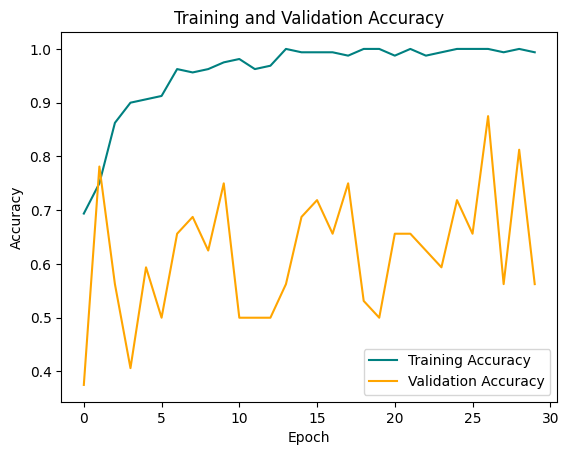

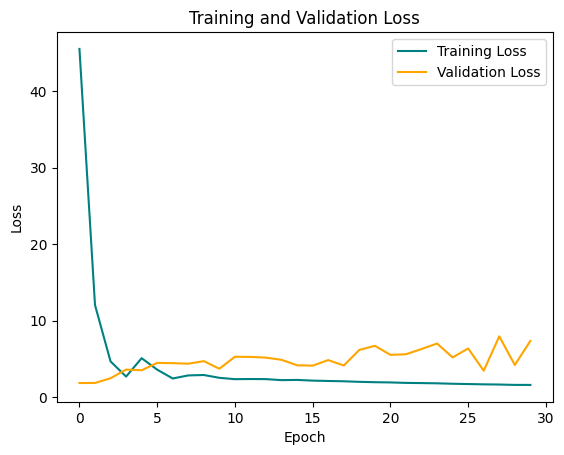

In [28]:
# Plot training and validation accuracy
plt.plot(hist.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist.history['loss'], color='teal', label='Training Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate the model on the test set

In [29]:
test_loss, test_accuracy = model.evaluate(test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Generate predictions for the test set
test_predictions = model.predict(test)
test_predictions = (test_predictions > 0.5).astype(int)

# Extract true labels from the test set
test_labels = []
for _, label in test:
    test_labels.append(label.numpy())

test_labels = np.concatenate(test_labels)

1/1 [==============================] - 1s 1s/step - loss: 5.0536 - accuracy: 0.7500
Test Loss: 5.053645133972168
Test Accuracy: 0.75
1/1 [==============================] - 1s 1s/step


Calculate confusion matrix

In [30]:
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 0 15]
 [ 0 17]]
